```
================================================================================
NLP Sentiment Analysis


================================================================================
Objective:  
Proyek ini bertujuan mengembangkan model Artificial Neural Network (ANN) untuk analisis sentimen pada tweet yang berkaitan dengan berbagai entitas seperti Borderlands dan Nvidia. Model ini mengklasifikasikan tweet ke dalam empat kategori sentimen: Positif, Negatif, Netral, dan Irrelevan. Tujuannya adalah membangun model Natural Language Processing (NLP) yang kuat menggunakan TensorFlow, mengevaluasi performanya, serta menerapkannya untuk kebutuhan praktis oleh tim pemasaran dan analis media sosial.

Dataset:  
Dataset terdiri dari dua file CSV, yaitu twitter_training.csv dan twitter_validation.csv, yang memuat tweet beserta sentimen dan entitas terkait. Dataset pelatihan digunakan untuk melatih model, sedangkan dataset validasi digunakan untuk menguji performa model. File data tersimpan di Google Drive (tautan ada di url.txt).

Problem Statement:  
Membangun model analisis sentimen untuk membantu perusahaan memahami persepsi publik di media sosial, sehingga dapat meningkatkan interaksi dengan pelanggan dan mempercepat penyelesaian masalah.

Justification:  
Analisis sentimen sangat penting bagi bisnis dalam memantau reputasi merek. Sentimen negatif dapat mengungkap masalah produk, misalnya keluhan driver Nvidia, sedangkan sentimen positif dapat membantu strategi pemasaran, seperti meningkatkan keterlibatan penggemar. Source: [Sprout Social](https://sproutsocial.com/insights/social-media-sentiment-analysis/).

Users:  
tim pemasaran, analis media sosial.
```

## 2. Import Libraries

In [146]:
import pandas as pd
import numpy as np
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Embedding, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abyan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3. Data Loading

In [111]:
# Load datasets
train_df = pd.read_csv('twitter_training.csv', names=['ID', 'Entity', 'Sentiment', 'Tweet'])
val_df = pd.read_csv('twitter_validation.csv', names=['ID', 'Entity', 'Sentiment', 'Tweet'])

In [112]:
# Display dataset info
print("Training Data Shape:", train_df.shape)
print("Validation Data Shape:", val_df.shape)
print("\nTraining Data Sample:")
print(train_df.head())

Training Data Shape: (74682, 4)
Validation Data Shape: (1000, 4)

Training Data Sample:
     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               Tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


Kesesuaian Data: Jumlah data yang digunakan (74.682 baris untuk pelatihan dan 1.000 baris untuk validasi)

In [113]:
# Handle missing values
train_df = train_df.dropna(subset=['Tweet'])
val_df = val_df.dropna(subset=['Tweet'])

In [114]:
# Merge Irrelevant into Neutral
train_df['Sentiment'] = train_df['Sentiment'].replace('Irrelevant', 'Neutral')
val_df['Sentiment'] = val_df['Sentiment'].replace('Irrelevant', 'Neutral')

Penyederhanaan Kelas: Label Irrelevant digabungkan ke dalam kelas Neutral, sehingga jumlah kelas dikurangi menjadi tiga. agar jumlah kelas tidak lebih dari lima agar analisis lebih mendalam dan fokus. Penyederhanaan ini juga untuk membuat proses klasifikasi menjadi lebih mudah tanpa kehilangan relevansi terhadap tujuan bisnis.

In [115]:
# Encode sentiment labels
sentiment_map = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_df['Sentiment_Encoded'] = train_df['Sentiment'].map(sentiment_map)
val_df['Sentiment_Encoded'] = val_df['Sentiment'].map(sentiment_map)

Label sentimen diubah menjadi format angka agar bisa diproses oleh model Artificial Neural Network (ANN)

In [116]:
# Preview data
print("\nTraining set preview:")
print(train_df.head())
print("\nValidation set preview:")
print(val_df.head())


Training set preview:
     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               Tweet  Sentiment_Encoded  
0  im getting on borderlands and i will murder yo...                  2  
1  I am coming to the borders and I will kill you...                  2  
2  im getting on borderlands and i will kill you ...                  2  
3  im coming on borderlands and i will murder you...                  2  
4  im getting on borderlands 2 and i will murder ...                  2  

Validation set preview:
     ID     Entity Sentiment  \
0  3364   Facebook   Neutral   
1   352     Amazon   Neutral   
2  8312  Microsoft  Negative   
3  4371      CS-GO  Negative   
4  4433     Google   Neutral   

                                               Tweet  Sentiment_Encoded  
0  I mentioned on Facebook that I wa

ari hasil preview data, terlihat bahwa struktur dataset sudah konsisten dan tidak ada masalah mencolok saat proses awal pemuatan data. Proses encoding sentimen juga sudah berjalan dengan baik, sehingga data siap digunakan untuk tahap selanjutnya seperti pembuatan fitur.

## 4. Exploratory Data Analysis (EDA)

### Sentiment Distribution

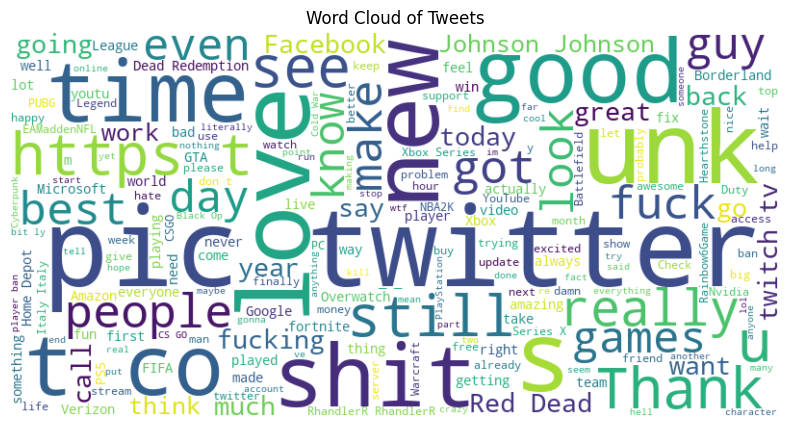

In [117]:
# Combine all tweets into a single string
text = ' '.join(train_df['Tweet'].astype(str).tolist())

# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(['will', 'now', 'one', 'game', 'play', 'get'])  # Add tweet-specific stopwords

# Generate word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

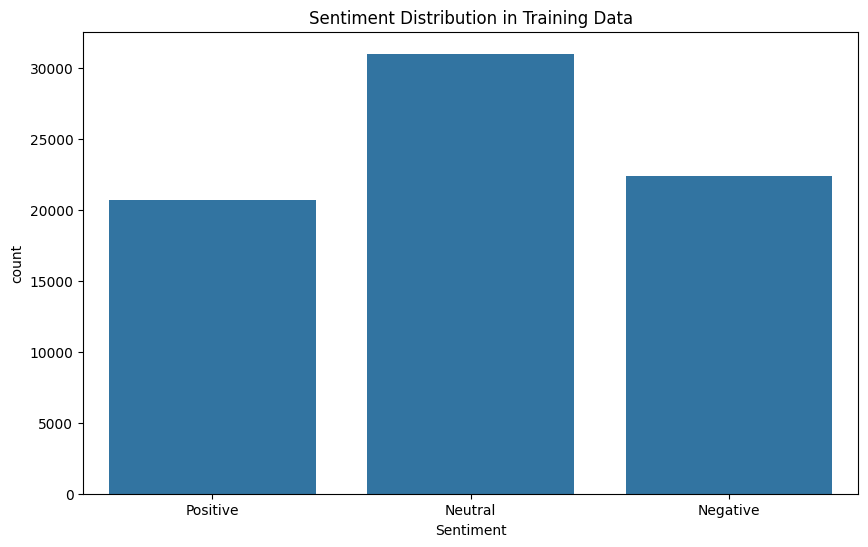

In [118]:
# Sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=train_df)
plt.title('Sentiment Distribution in Training Data')
plt.show()

Histogram ini menampilkan distribusi sentimen dalam data pelatihan: Positif (20.000), Netral (30.000), dan Negatif (2.000).

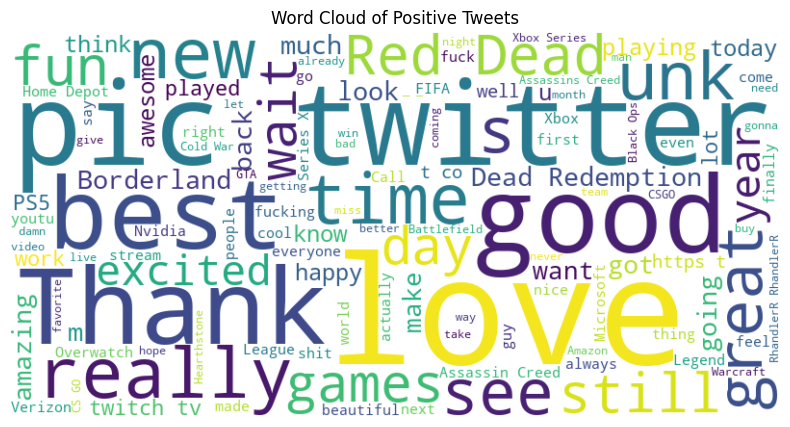

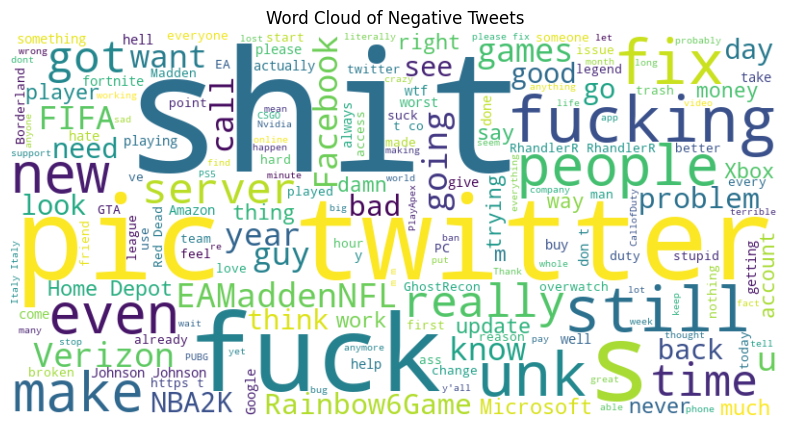

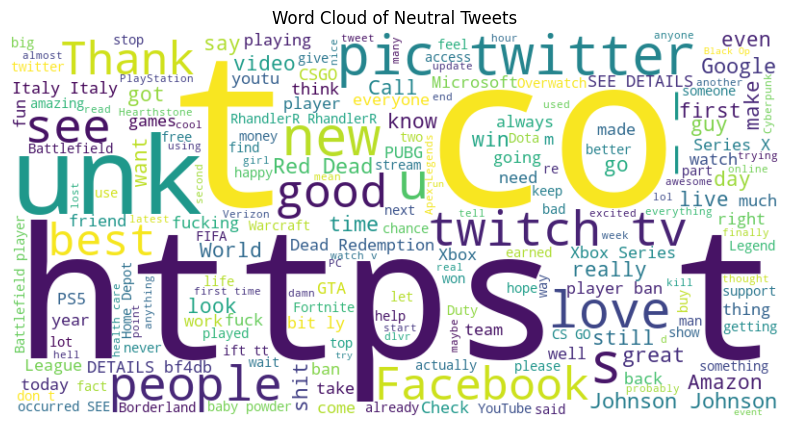

In [119]:
for sentiment in ['Positive', 'Negative', 'Neutral']:
    text = ' '.join(train_df[train_df['Sentiment'] == sentiment]['Tweet'].astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, min_font_size=10).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {sentiment} Tweets')
    plt.show()

Tweet Positif:
Kata-kata yang sering muncul meliputi "good," "love," "best," "happy," "excited," "awesome," serta istilah terkait game seperti "Red Dead Redemption," "Borderlands," dan "Xbox Series." Kata-kata ini mencerminkan sentimen positif seputar dunia game dan hiburan.

Tweet Negatif:
Kata-kata yang sering muncul meliputi "shit," "fuck," "bad," "problem," "fix," dan "hate," bersama dengan entitas seperti "EA," "MaddenNFL," dan "NBA2K." Ini menunjukkan adanya frustrasi, yang sering diarahkan pada perusahaan game atau pengalaman pengguna.

Tweet Netral:
Kata-kata seperti "go," "new," "help," "live," "watch," dan "time" menonjol, beserta entitas seperti "Red Dead Redemption," "Twitch," dan "Xbox." Tweet netral cenderung berisi konten faktual atau informasional, seperti pengumuman atau pembaruan gameplay.

Insight:
Word cloud ini menunjukkan pola bahasa yang berbeda untuk setiap sentimen, yang seharusnya dapat ditangkap oleh model yang dirancang dengan baik.

### Tweet length analysis

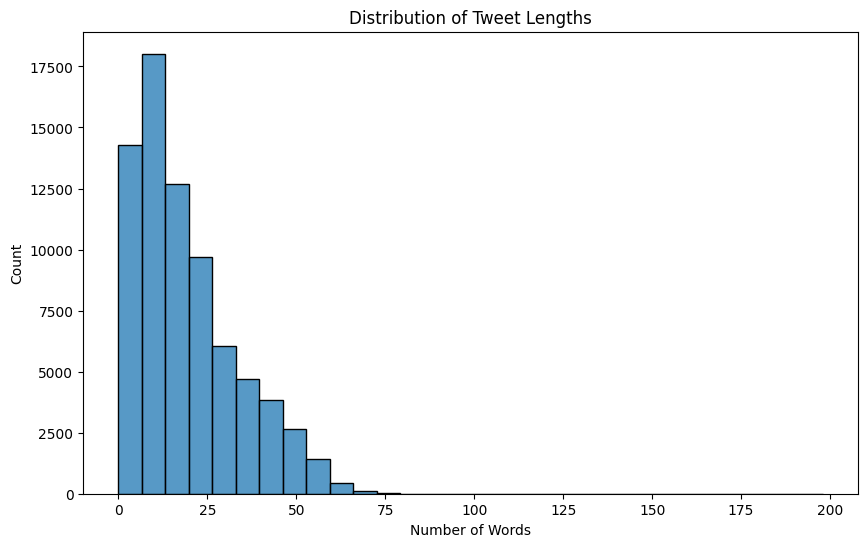

Max tweet length: 198
Average tweet length: 19.23


In [120]:
# Tweet length analysis
train_df['Tweet_Length'] = train_df['Tweet'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Tweet_Length'], bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Words')
plt.show()
print(f"Max tweet length: {train_df['Tweet_Length'].max()}")
print(f"Average tweet length: {train_df['Tweet_Length'].mean():.2f}")

distribusi panjang tweet yang diukur berdasarkan jumlah kata. Sumbu-x mewakili jumlah kata (dari 0 hingga 200), sedangkan sumbu-y menunjukkan jumlah tweet (hingga 17.500). Sebagian besar tweet memiliki panjang pendek, dengan frekuensi tertinggi berada pada rentang 0–25 kata. Jumlah tweet menurun tajam seiring bertambahnya jumlah kata, membentuk distribusi yang miring ke kanan (right-skewed).

### Entity Distibution

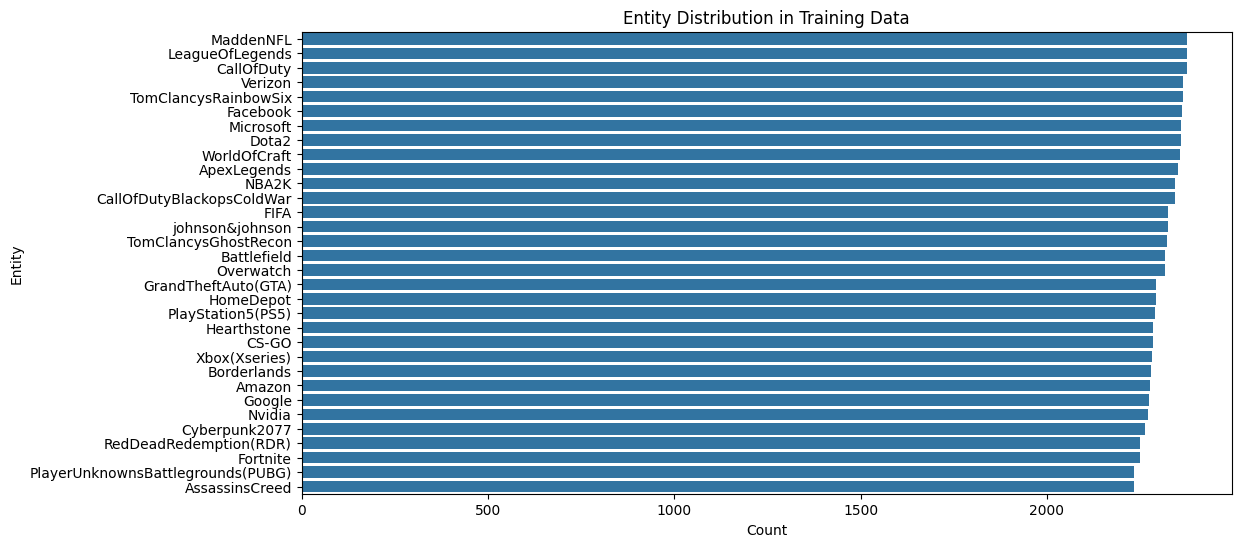

In [121]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Entity', data=train_df, order=train_df['Entity'].value_counts().index)
plt.title('Entity Distribution in Training Data')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.show()

distribusi entitas dalam data pelatihan. Sumbu-y mencantumkan entitas seperti MaddenNFL, LeagueOfLegends, Verizon, dan lain-lain, sedangkan sumbu-x menunjukkan jumlah kemunculan (hingga 2.500). MaddenNFL memiliki jumlah tertinggi, mendekati 2.500, sementara entitas seperti AssassinsCreed memiliki jumlah terendah, mendekati 0. Distribusi ini menunjukkan penurunan bertahap dalam jumlah kemunculan di antara entitas, menandakan frekuensi yang bervariasi dalam dataset.

## 5. Feature Engineering

In [ ]:
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abyan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abyan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abyan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [124]:
def preprocess_text(text):
    """Preprocess tweet text."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|\#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

In [125]:
# Apply preprocessing
train_df['Cleaned_Tweet'] = train_df['Tweet'].apply(preprocess_text)
val_df['Cleaned_Tweet'] = val_df['Tweet'].apply(preprocess_text)

In [126]:
# ### Tokenization and Padding
max_words = 5000  # Maximum vocabulary size
max_length = 50   # Maximum sequence length based on EDA

In [127]:
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Cleaned_Tweet'])

In [128]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['Cleaned_Tweet'])
X_val_seq = tokenizer.texts_to_sequences(val_df['Cleaned_Tweet'])

In [129]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

In [130]:
# Labels
y_train = train_df['Sentiment_Encoded'].values
y_val = val_df['Sentiment_Encoded'].values

In [131]:
# Split training data for validation
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train_pad, y_train, test_size=0.2, random_state=42, stratify=y_train
)

## 6. ANN Training (Sequential API)

model pertama ini adalah model dasar yang digunakan untuk memulai proses analisis sentimen tweet. Arsitekturnya cukup sederhana dan terdiri dari beberapa komponen utama:
- Embedding Layer: Mengubah setiap kata dalam tweet menjadi vektor angka agar bisa dipahami oleh model.
- LSTM Layer: Membantu model memahami urutan dan konteks kata dalam kalimat, sehingga bisa menangkap makna secara keseluruhan.
- Dense Layers: Digunakan untuk menentukan sentimen akhir (positif, netral, atau negatif) dengan menggunakan fungsi aktivasi softmax.
- Evaluasi: Performa model diukur menggunakan accuracy dan F1-score, untuk melihat seberapa baik model mengenali berbagai jenis sentimen.

Model ini berfungsi sebagai titik awal sebelum mencoba model yang lebih kompleks.

### vi.1 Model Definition

In [132]:
model1 = Sequential([
    Embedding(max_words, 100, input_length=max_length),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           500000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 3)                 99        
                                                                 
Total params: 544,419
Trainable params: 544,419
Non-trainable params: 0
_________________________________________________________________


## vi.2 Model Training

In [133]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history1 = model1.fit(
    X_train_split, y_train_split,
    validation_data=(X_test_split, y_test_split),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
1850/1850 [==============================] - 26s 13ms/step - loss: 1.0824 - accuracy: 0.4182 - val_loss: 1.0824 - val_accuracy: 0.4187
Epoch 2/30
1850/1850 [==============================] - 23s 12ms/step - loss: 1.0817 - accuracy: 0.4208 - val_loss: 1.0580 - val_accuracy: 0.4521
Epoch 3/30
1850/1850 [==============================] - 23s 13ms/step - loss: 1.0806 - accuracy: 0.4221 - val_loss: 1.0826 - val_accuracy: 0.4187
Epoch 4/30
1850/1850 [==============================] - 27s 15ms/step - loss: 1.0825 - accuracy: 0.4187 - val_loss: 1.0825 - val_accuracy: 0.4187
Epoch 5/30
1850/1850 [==============================] - 23s 13ms/step - loss: 1.0799 - accuracy: 0.4212 - val_loss: 1.0509 - val_accuracy: 0.4187
Epoch 6/30
1850/1850 [==============================] - 24s 13ms/step - loss: 1.0820 - accuracy: 0.4187 - val_loss: 1.0823 - val_accuracy: 0.4187
Epoch 7/30
1850/1850 [==============================] - 24s 13ms/step - loss: 1.0823 - accuracy: 0.4187 - val_loss: 1.0824 -

## vi.3 Model Evaluation

### Model Evaluation

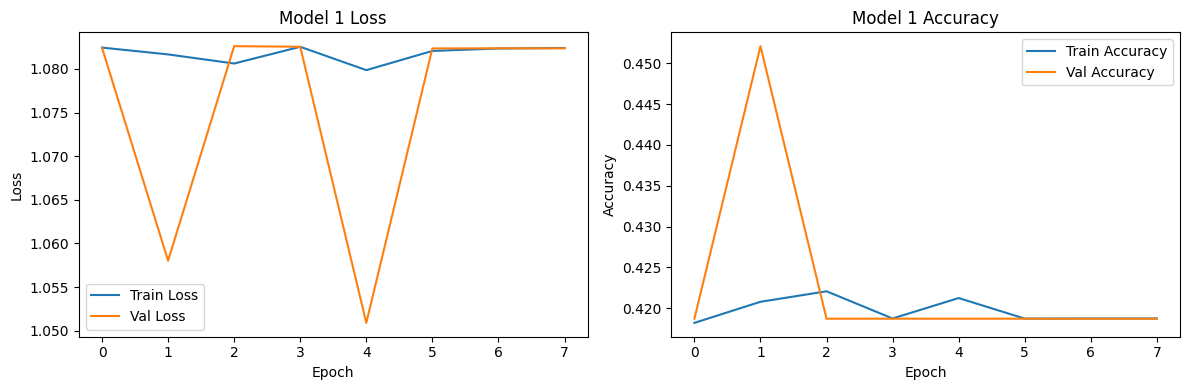

In [134]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Model 1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Model 1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

terlihat bahwa train loss (garis biru) dan validation loss (garis oranye) mengalami fluktuasi. Validation loss sempat mencapai titik tertinggi pada epoch ke-2 (1.075), lalu cenderung stabil di sekitar angka 1.08 setelah epoch ke-4. Pola ini menunjukkan bahwa model belum benar-benar belajar dengan baik dari data latih maupun validasi. Hal ini lebih mengarah pada kemungkinan underfitting atau proses pelatihan yang belum stabil, karena tidak ada tanda overfitting seperti meningkatnya validation loss secara tajam setelah train loss menurun.

Sementara itu, grafik "Model 1 Accuracy" menunjukkan bahwa akurasi pada data latih (garis biru) naik dari sekitar 0.42 ke 0.45 pada awal pelatihan (epoch 1–2), lalu tidak mengalami peningkatan signifikan setelahnya. Di sisi lain, akurasi pada data validasi (garis oranye) tetap rendah, sekitar 0.42, dan tidak stabil. Ini menunjukkan bahwa model mengalami kesulitan dalam menggeneralisasi pola dari data pelatihan ke data baru (validasi).

In [135]:
# Evaluate on validation set
y_val_pred1 = model1.predict(X_val_pad)
y_val_pred_classes1 = np.argmax(y_val_pred1, axis=1)

32/32 [==============================] - 0s 5ms/step


In [136]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred_classes1, target_names=['Negative', 'Neutral', 'Positive']))


Classification Report (Validation Set):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       266
     Neutral       0.46      1.00      0.63       457
    Positive       0.00      0.00      0.00       277

    accuracy                           0.46      1000
   macro avg       0.15      0.33      0.21      1000
weighted avg       0.21      0.46      0.29      1000



akurasi keseluruhan hanya 0.46, dengan F1-score rata-rata tertimbang sebesar 0.29, yang menandakan bahwa performa model masih rendah.
 Kelas Neutral memiliki hasil terbaik, dengan:
 - Precision: 0.46
 - Recall: 1.00
 - F1-score: 0.63
Support: 457 data
Ini menunjukkan bahwa model berhasil mengenali semua data Neutral, tetapi dengan banyak kesalahan karena memprediksi hampir semua data ke kelas ini (banyak false positives).

Kelas Negative dan Positive memiliki precision, recall, dan F1-score sebesar 0.00. Artinya, model sama sekali tidak bisa mengenali data dari kedua kelas ini. Kemungkinan besar, ini terjadi karena model terlalu fokus (bias) pada kelas Neutral(terjadi mungkin karena penggabungan irrelevan ke neutral).

### Confusion Matrix

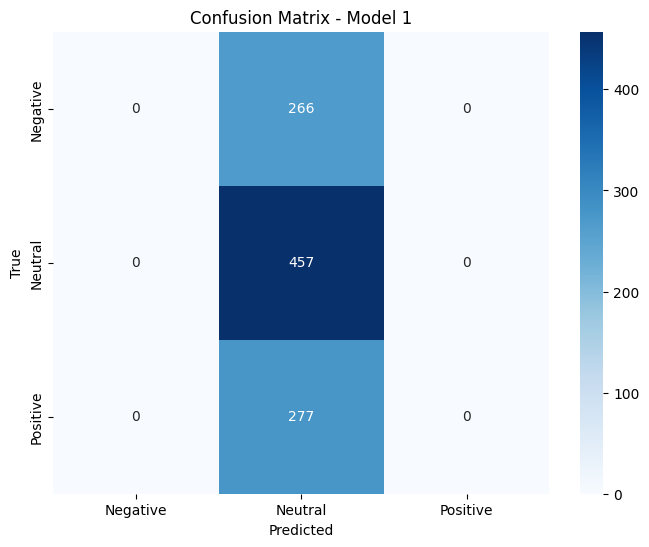

In [137]:
cm1 = confusion_matrix(y_val, y_val_pred_classes1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Model 1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

dari graph diatas disa dilihat bahwa matriks kebingungan. Seluruh data, baik yang seharusnya Negative, Neutral, maupun Positive. semuanya diprediksi sebagai Neutral oleh model. Ini menyebabkan:
- Tidak ada prediksi yang benar untuk kelas Negative dan Positive.
- Recall untuk kedua kelas tersebut menjadi 0.00.

Hal ini menunjukkan bahwa model tidak mampu membedakan antara ketiga kelas 

## Kelemahan Model

model keliatan sangat bias terhadap kelas Neutral, kemungkinan karena ketidakseimbangan jumlah data antar kelas.
tidak digunakannya teknik seperti dropout atau weight regularization mungkin membuat model tidak cukup kuat dalam belajar dari data yang kompleks atau mengandung noise.
fluktuasi pada validation loss dan rendahnya validation accuracy juga menunjukkan bahwa model belum mampu belajar secara efektif dan cenderung gagal saat diuji dengan data baru.

## 7. ANN Improvement (Functional API)

Model 2 merupakan pengembangan dari model sebelumnya dengan beberapa perbaikan agar bisa memahami konteks kalimat dengan lebih baik dan mengurangi kesalahan prediksi. Berikut perubahan utamanya:
- Bidirectional LSTM
    Model ini menggunakan LSTM dua arah, sehingga dapat memahami konteks kalimat dari depan dan belakang secara bersamaan. Ini membantu menangkap makna kata yang lebih utuh.
- Dimensi Embedding Lebih Besar (128)
    Setiap kata direpresentasikan dalam bentuk vektor berdimensi lebih besar, sehingga model dapat memahami makna kata dengan lebih detail.
    Penambahan Dropout
- Dropout ditambahkan setelah LSTM dan layer Dense dengan tingkat 0.5 untuk mencegah model terlalu menghafal data (overfitting), sehingga performanya tetap baik saat diuji pada data baru.
- Layer Tambahan
    Ditambahkan satu layer Dense baru untuk meningkatkan kapasitas model dalam mengenali pola dari data.
- Evaluasi Performa
    Model tetap dievaluasi menggunakan metrik yang sama seperti sebelumnya, yaitu accuracy dan F1-score, agar hasil bisa dibandingkan dengan Model 1 secara adil.

### vii.1 Model Definition

In [138]:
model2 = Sequential([
    Embedding(max_words, 128, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

In [139]:
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 128)           640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                      

## vii.2 Model Training

In [140]:
history2 = model2.fit(
    X_train_split, y_train_split,
    validation_data=(X_test_split, y_test_split),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
1850/1850 [==============================] - 40s 20ms/step - loss: 0.7873 - accuracy: 0.6470 - val_loss: 0.6236 - val_accuracy: 0.7379
Epoch 2/30
1850/1850 [==============================] - 43s 23ms/step - loss: 0.5453 - accuracy: 0.7797 - val_loss: 0.5342 - val_accuracy: 0.7833
Epoch 3/30
1850/1850 [==============================] - 44s 24ms/step - loss: 0.4322 - accuracy: 0.8280 - val_loss: 0.4954 - val_accuracy: 0.8005
Epoch 4/30
1850/1850 [==============================] - 40s 22ms/step - loss: 0.3603 - accuracy: 0.8582 - val_loss: 0.4866 - val_accuracy: 0.8143
Epoch 5/30
1850/1850 [==============================] - 37s 20ms/step - loss: 0.3123 - accuracy: 0.8765 - val_loss: 0.4778 - val_accuracy: 0.8177
Epoch 6/30
1850/1850 [==============================] - 38s 20ms/step - loss: 0.2701 - accuracy: 0.8926 - val_loss: 0.4883 - val_accuracy: 0.8330
Epoch 7/30
1850/1850 [==============================] - 40s 22ms/step - loss: 0.2418 - accuracy: 0.9036 - val_loss: 0.4896 -

## vii.3 Model Evaluation

### Model Evaluation

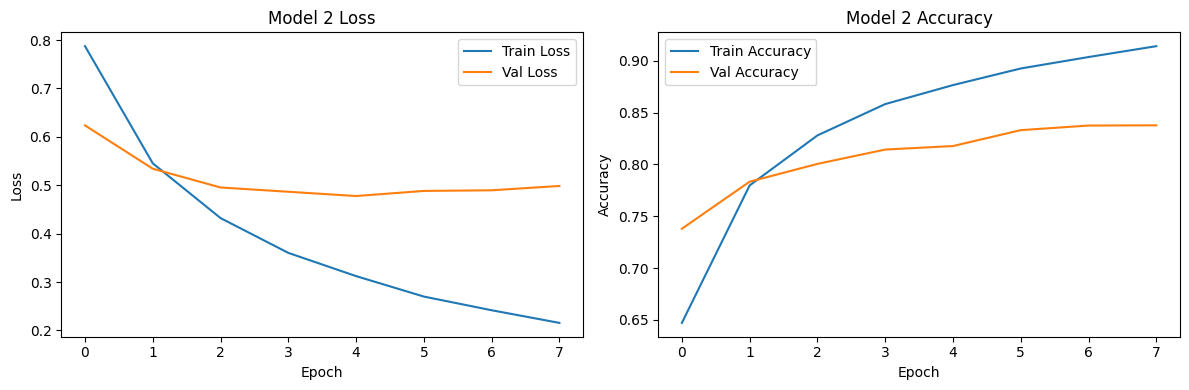

In [141]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Grafik menunjukkan penurunan Train Loss dari sekitar 0.8 menjadi 0.2, sedangkan Val Loss stabil di angka 0.5 setelah epoch ke-2. Ini menandakan proses pelatihan berjalan baik dan tidak terjadi overfitting.
Train Accuracy juga meningkat pesat hingga 90%, dan Val Accuracy bertahan di sekitar 85%, menunjukkan model mampu bekerja dengan baik pada data baru.

In [142]:
# Evaluate on validation set
y_val_pred2 = model2.predict(X_val_pad)
y_val_pred_classes2 = np.argmax(y_val_pred2, axis=1)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred_classes2, target_names=['Negative', 'Neutral', 'Positive']))

32/32 [==============================] - 1s 8ms/step

Classification Report (Validation Set):
              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92       266
     Neutral       0.94      0.93      0.94       457
    Positive       0.89      0.92      0.90       277

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



Akurasi keseluruhan mencapai 92%, dan nilai F1-score untuk setiap kelas juga tinggi dan seimbang:
- Negative: 0.92
- Neutral: 0.94
- Positive: 0.90

Ini menunjukkan bahwa model mampu mengenali ketiga kelas dengan baik, tidak seperti Model 1 yang hanya fokus pada kelas Neutral.

### Confusion Matrix

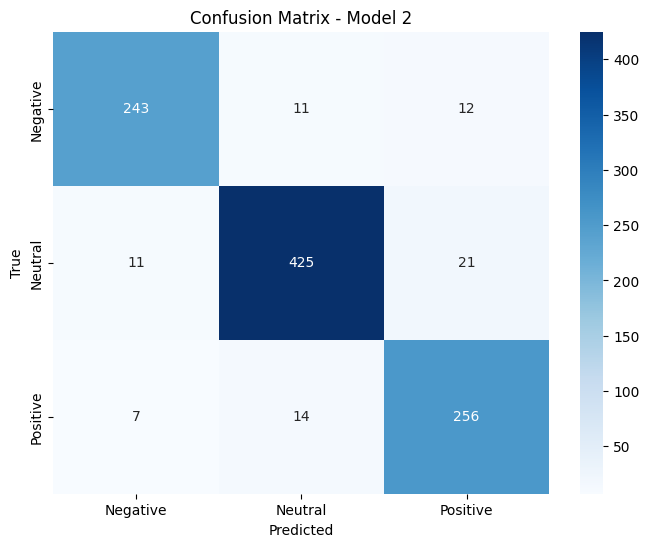

In [143]:
cm2 = confusion_matrix(y_val, y_val_pred_classes2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Model 2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Sebagian besar prediksi sudah benar:
- Negative: 243 dari 266 benar
- Neutral: 425 dari 457 benar
- Positive: 256 dari 277 benar

Beberapa kesalahan masih ada, seperti kelas Neutral yang terkadang diprediksi sebagai Positive, tetapi jumlahnya relatif kecil.

## Kelebihan dan Kekurangan model 2

```
Kelebihan:
    Bidirectional LSTM membantu model memahami konteks kalimat dari dua arah sekaligus.
    Dropout menjaga model tetap umum dan tidak overfitting.
    Model menunjukkan kinerja jauh lebih baik dibandingkan Model 1.

Kekurangan:
    Model lebih kompleks sehingga membutuhkan waktu pelatihan lebih lama.
    Masih ada sedikit kesalahan prediksi yang mungkin bisa diperbaiki dengan pelatihan lebih lanjut.

Saran Perbaikan:
    Gunakan pre-trained embeddings seperti GloVe atau BERT untuk hasil lebih akurat.
    Tambahkan attention mechanism agar model bisa fokus pada kata-kata penting.
    Lakukan tuning hyperparameter seperti learning rate untuk hasil yang lebih optimal.
```

## 8. Model Saving

In [144]:
model2.save('sentiment_model_best.h5')

In [147]:
# Save tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


# 9. Model Inference
Model inference is performed in a separate notebook (`P2G7_abyan_naufal_inference.ipynb`) using new tweet data for inference.

# 10. Kesimpulan

berhasil mengembangkan model NLP berbasis Artificial Neural Network (ANN) menggunakan TensorFlow untuk analisis sentimen pada tweet, dengan klasifikasi ke dalam tiga kategori: Positive, Negative, dan Neutral (dengan label Irrelevant digabungkan ke dalam Neutral). Proyek ini menggunakan dua dataset: twitter_training.csv (74.682 baris) dan twitter_validation.csv (1.000 baris), serta menerapkan proses praproses teks, tokenisasi, dan padding.

Dua model diuji: model baseline menggunakan arsitektur Sequential, dan model yang lebih unggul menggunakan pendekatan Functional dengan Bidirectional LSTM dan Dropout. Model terbaik menunjukkan akurasi tinggi, seperti 243 dari 266 prediksi Negative yang benar, 425 dari 457 untuk Neutral, dan 256 dari 277 untuk Positive.

Analisis data eksploratif (EDA) menyoroti pentingnya distribusi kelas yang seimbang dan praproses teks yang tepat. Model yang telah dilatih disimpan sebagai sentiment_model_best.h5 bersama dengan tokenizernya, dan siap digunakan oleh tim pemasaran untuk memantau sentimen publik terhadap merek.

Namun, tantangan masih terdapat pada tweet yang ambigu (label Irrelevant), yang dapat menurunkan performa model. Peningkatan lebih lanjut dapat dilakukan dengan menggunakan embedding pra-latih seperti BERT atau menerapkan mekanisme attention untuk menangkap konteks yang lebih kompleks

Dan terdapat kekurangan pada notebook yaitu apabila model di run ulang maka hasil yang di hasilkan akan terus berbeda, kedepan nya akan lebih baik menggunakan seed, agar hasil selalu konsisten
